# Deep Dream

How it works:

Takes an image and reverses gradient descent to compute the maximum activation of a selected layer. This mixes a large number of features from this layer together.

Starting with the input image, this image is processed at multiple scales. After each scale it is upsampled. To compensate for the quality loss through upsampling, the target image is fed in after each sampling step.


In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3
from IPython.display import Image, display
from csv import writer

Init Plugin
Init Graph Optimizer
Init Kernel


# Load image and preprocess

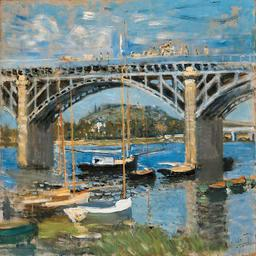

In [21]:
# Load image
image_path_in = "../../data/art/monet_jpg/"

image_name_in = "10c555c1b1.jpg" #"sky.jpg"
result_prefix = image_name_in.split(".")[0] + "_dream-3"

base_image_path = image_path_in + image_name_in
display(Image(base_image_path))

In [3]:
# Preprocess image, decompress image
def preprocess_image(image_path):
    # Opens, resizes and formats images.
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def decompress_image(x):
    # Converts a numpy array into a valid image.
    x = x.reshape((x.shape[1], x.shape[2], 3))

    # Undo inception preprocessing
    x /= 2.0
    x += 0.5
    x *= 255.0

    x = np.clip(x, 0, 255).astype("uint8")
    return x

# Load model

In [4]:
# Set up the model
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)
model.summary()

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-10-23 21:29:34.562862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-10-23 21:29:34.562952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
# Layer names for which we maximize the activation mapped to their weight in the final loss function.
# Changing these weights and the layers changes the results
#
# Earlier layers -> Tend to generate more abstract images
# Later layers -> Tends to add more visual artifacts found in imagenet classes, such as eyes
layer_settings = {
    "mixed4": 1.0,
    "mixed6": 2.0,
    "mixed7": 2.5,
    "mixed9": 4.0,
    "mixed10": 5.0,
    
}

# Get symbolic oututs for each "key" layer.
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)


feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [18]:
# Loss function
def compute_loss(input_image):
    features = feature_extractor(input_image) # Layer_name -> layer activation
    # Initialize the loss
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name] # Selected weight of this layer
        activation = features[name]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:,2:-2,2:-2,:])) / scaling
    return loss

In [19]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)

    # Compute gradients
    grads = tape.gradient(loss,img)
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img


# Run the model

In [20]:
# Playing with these hyperparameters will also allow you to achieve new effects
step = 0.01  # Gradient ascent step size
num_octave = 4  # Number of scales at which to run gradient ascent
octave_scale = 1.2  # Size ratio between scales
iterations = 30  # Number of ascent steps per scale
max_loss = 20.0

In [22]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]

# Starting from the smallest shape, the image is upsampled in each step.
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0]) # Add original image

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

# Document parameters of run to runs.csv
logs = [image_name_in,result_prefix,layer_settings,step, num_octave, octave_scale, iterations, max_loss]
with open("runs.csv", "a") as f:
    csv_writer = writer(f)
    csv_writer.writerow([str(log) for log in logs])

keras.preprocessing.image.save_img("results/" + result_prefix + ".png", decompress_image(img.numpy()))

Processing octave 0 with shape (148, 148)


2021-10-23 21:31:41.050349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 0.20
... Loss value at step 1: 0.39
... Loss value at step 2: 0.61
... Loss value at step 3: 0.87
... Loss value at step 4: 0.98
... Loss value at step 5: 1.18
... Loss value at step 6: 1.28
... Loss value at step 7: 1.42
... Loss value at step 8: 1.50
... Loss value at step 9: 1.70
... Loss value at step 10: 1.83
... Loss value at step 11: 2.10
... Loss value at step 12: 2.32
... Loss value at step 13: 2.35
... Loss value at step 14: 2.56
... Loss value at step 15: 2.43
... Loss value at step 16: 2.54
... Loss value at step 17: 2.80
... Loss value at step 18: 2.85
... Loss value at step 19: 3.03
... Loss value at step 20: 3.14
... Loss value at step 21: 3.25
... Loss value at step 22: 3.43
... Loss value at step 23: 3.55
... Loss value at step 24: 3.71
... Loss value at step 25: 3.72
... Loss value at step 26: 3.73
... Loss value at step 27: 3.85
... Loss value at step 28: 4.04
... Loss value at step 29: 4.31
Processing octave 1 with shape (177, 177)


2021-10-23 21:31:43.508731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 0.58
... Loss value at step 1: 1.15
... Loss value at step 2: 1.56
... Loss value at step 3: 1.84
... Loss value at step 4: 2.17
... Loss value at step 5: 2.23
... Loss value at step 6: 2.42
... Loss value at step 7: 2.70
... Loss value at step 8: 3.11
... Loss value at step 9: 3.28
... Loss value at step 10: 3.76
... Loss value at step 11: 3.70
... Loss value at step 12: 4.02
... Loss value at step 13: 3.93
... Loss value at step 14: 4.08
... Loss value at step 15: 4.37
... Loss value at step 16: 4.57
... Loss value at step 17: 4.86
... Loss value at step 18: 4.86
... Loss value at step 19: 5.39
... Loss value at step 20: 5.42
... Loss value at step 21: 5.78
... Loss value at step 22: 5.88
... Loss value at step 23: 6.17
... Loss value at step 24: 6.50
... Loss value at step 25: 6.48
... Loss value at step 26: 6.66
... Loss value at step 27: 6.78
... Loss value at step 28: 6.71
... Loss value at step 29: 7.17
Processing octave 2 with shape (213, 213)


2021-10-23 21:31:46.025095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 1.56
... Loss value at step 1: 2.85
... Loss value at step 2: 3.36
... Loss value at step 3: 4.45
... Loss value at step 4: 4.11
... Loss value at step 5: 6.39
... Loss value at step 6: 7.81
... Loss value at step 7: 6.79
... Loss value at step 8: 7.30
... Loss value at step 9: 5.95
... Loss value at step 10: 8.83
... Loss value at step 11: 10.14
... Loss value at step 12: 10.01
... Loss value at step 13: 9.99
... Loss value at step 14: 10.53
... Loss value at step 15: 11.19
... Loss value at step 16: 10.68
... Loss value at step 17: 11.65
... Loss value at step 18: 14.27
... Loss value at step 19: 13.29
... Loss value at step 20: 16.57
... Loss value at step 21: 15.98
... Loss value at step 22: 15.86
... Loss value at step 23: 15.25
... Loss value at step 24: 17.93
... Loss value at step 25: 19.60
Processing octave 3 with shape (256, 256)


2021-10-23 21:31:48.484077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


... Loss value at step 0: 3.98
... Loss value at step 1: 4.76
... Loss value at step 2: 9.68
... Loss value at step 3: 12.79
... Loss value at step 4: 14.83
... Loss value at step 5: 18.90


# Visualize results

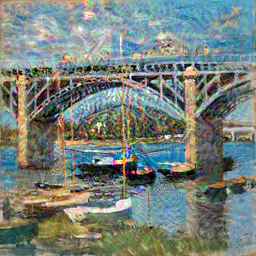

In [23]:
# Display result
display(Image("results/" + result_prefix + ".png"))